In [26]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
from torchvision.models import vgg19
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from torch.amp import autocast, GradScaler
import torchmetrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

✅ Using device: cuda


In [27]:
JSON_FILE_PATH = "./VOC2012/VOC_results_list.json"

# Load the main JSON file
try:
    with open(JSON_FILE_PATH, 'r') as f:
        all_image_pairs = json.load(f)

    # Split the list of image pairs into 80% training and 20% validation
    train_pairs, val_pairs = train_test_split(all_image_pairs, test_size=0.2, random_state=42)

    # Save the split lists to new JSON files in the current directory
    with open('train_list.json', 'w') as f:
        json.dump(train_pairs, f, indent=4)
    with open('val_list.json', 'w') as f:
        json.dump(val_pairs, f, indent=4)
    
    print(f"✅ Data split into {len(train_pairs)} training pairs and {len(val_pairs)} validation pairs.")
    print("✅ Created 'train_list.json' and 'val_list.json'.")

except FileNotFoundError:
    print(f"❌ Error: The file '{JSON_FILE_PATH}' was not found. Please update the path.")
    # Create dummy files to allow the rest of the script to run without error
    with open('train_list.json', 'w') as f: json.dump([], f)
    with open('val_list.json', 'w') as f: json.dump([], f)

✅ Data split into 6114 training pairs and 1529 validation pairs.
✅ Created 'train_list.json' and 'val_list.json'.


In [28]:
class ReflectionDataset(Dataset):
    """
    Custom Dataset for loading reflection removal data.
    - Uses a JSON file to correctly pair images.
    - Handles images smaller than the crop size by resizing them first.
    - Applies synchronized random cropping for training, resizing for validation.
    """
    def __init__(self, root_dir, json_path, crop_size=(224, 224), is_train=True):
        self.root_dir = root_dir
        self.is_train = is_train
        self.crop_size = crop_size
        self.json_path = json_path
        
        self.blended_dir = os.path.join(root_dir, 'blended')
        self.transmission_dir = os.path.join(root_dir, 'transmission_layer')
        self.reflection_dir = os.path.join(root_dir, 'reflection_layer')
        
        try:
            with open(json_path, 'r') as f:
                self.image_pairs = json.load(f)
        except FileNotFoundError:
            print(f"❌ Warning: JSON file not found at {json_path}. Dataset will be empty.")
            self.image_pairs = []

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        pair_info = self.image_pairs[idx]
        blended_fn = pair_info['blended']
        transmission_fn = pair_info['transmission_layer']
        reflection_fn = pair_info['reflection_layer']
        
        blended_img = Image.open(os.path.join(self.blended_dir, blended_fn)).convert('RGB')
        transmission_img = Image.open(os.path.join(self.transmission_dir, transmission_fn)).convert('RGB')
        reflection_img = Image.open(os.path.join(self.reflection_dir, reflection_fn)).convert('RGB')
        
        if self.is_train:
            # --- FIX IS HERE ---
            # Check if image is smaller than crop size
            if blended_img.size[0] < self.crop_size[1] or blended_img.size[1] < self.crop_size[0]:
                # Resize the smaller edge to the crop size, maintaining aspect ratio
                blended_img = TF.resize(blended_img, self.crop_size[0], interpolation=TF.InterpolationMode.BICUBIC)
                transmission_img = TF.resize(transmission_img, self.crop_size[0], interpolation=TF.InterpolationMode.BICUBIC)
                reflection_img = TF.resize(reflection_img, self.crop_size[0], interpolation=TF.InterpolationMode.BICUBIC)
            
            # Now perform the random crop, which is guaranteed to work
            i, j, h, w = transforms.RandomCrop.get_params(blended_img, output_size=self.crop_size)
            blended_img = TF.crop(blended_img, i, j, h, w)
            transmission_img = TF.crop(transmission_img, i, j, h, w)
            reflection_img = TF.crop(reflection_img, i, j, h, w)
        else:
            # For validation/testing, just resize
            blended_img = TF.resize(blended_img, self.crop_size, interpolation=TF.InterpolationMode.BICUBIC)
            transmission_img = TF.resize(transmission_img, self.crop_size, interpolation=TF.InterpolationMode.BICUBIC)
            reflection_img = TF.resize(reflection_img, self.crop_size, interpolation=TF.InterpolationMode.BICUBIC)

        return {
            'blended': TF.to_tensor(blended_img),
            'transmission': TF.to_tensor(transmission_img),
            'reflection': TF.to_tensor(reflection_img)
        }

✅ DataLoaders created.
Displaying one sample from the training loader...


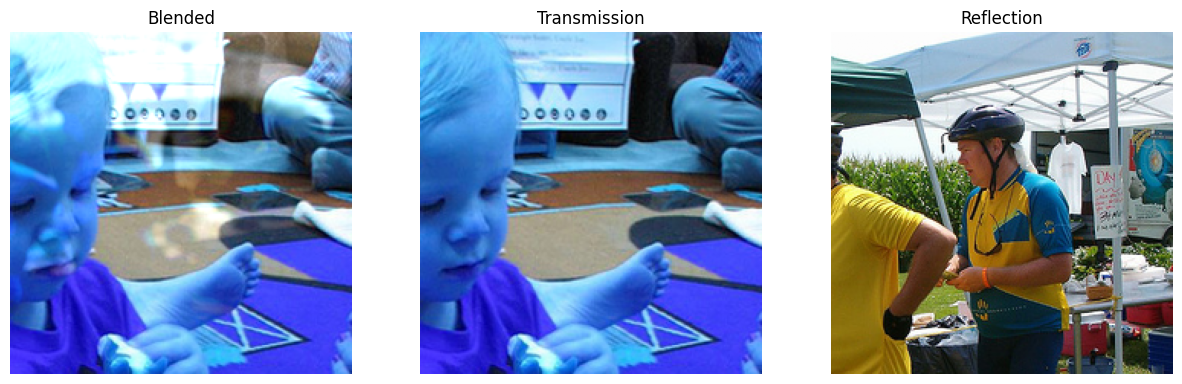

In [29]:
BATCH_SIZE = 64
DATASET_ROOT_PATH = "./VOC2012" 

# --- Set num_workers=0 because of the Jupyter bug ---
train_dataset = ReflectionDataset(root_dir=DATASET_ROOT_PATH, json_path='train_list.json', is_train=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

val_dataset = ReflectionDataset(root_dir=DATASET_ROOT_PATH, json_path='val_list.json', is_train=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"✅ DataLoaders created.")

def show_sample(data_sample):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for ax, (key, image) in zip(axs, data_sample.items()):
        img_np = image.squeeze().permute(1, 2, 0).numpy()
        ax.imshow(img_np)
        ax.set_title(key.replace('_', ' ').title())
        ax.axis('off')
    plt.show()

# Visualize one sample from the training set
if len(train_dataset) > 0:
    print("Displaying one sample from the training loader...")
    sample = next(iter(train_loader))
    first_image_sample = {k: v[0].unsqueeze(0) for k, v in sample.items()}
    show_sample(first_image_sample)
        
else:
    print("⚠️ Training dataset is empty. Cannot display sample.")


In [30]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, 1, 1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, 1, 1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)

class UNet_ResNet50(nn.Module):
    def __init__(self):
        super(UNet_ResNet50, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters(): param.requires_grad = False
        
        self.encoder_conv1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)
        self.encoder_pool1 = resnet.maxpool
        self.encoder_layer1 = resnet.layer1
        self.encoder_layer2 = resnet.layer2
        self.encoder_layer3 = resnet.layer3
        self.encoder_layer4 = resnet.layer4

        self.up1 = nn.ConvTranspose2d(2048, 1024, 2, 2); self.conv1 = DoubleConv(2048, 1024)
        self.up2 = nn.ConvTranspose2d(1024, 512, 2, 2); self.conv2 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2); self.conv3 = DoubleConv(512, 256)
        self.up4 = nn.ConvTranspose2d(256, 64, 2, 2); self.conv4 = DoubleConv(128, 64)
        self.up5 = nn.ConvTranspose2d(64, 32, 2, 2); self.conv5 = DoubleConv(32, 32)
        
        self.out_transmission = nn.Conv2d(32, 3, 1)
        self.out_reflection = nn.Conv2d(32, 3, 1)

    def forward(self, x):
        x1 = self.encoder_conv1(x)
        x2 = self.encoder_layer1(self.encoder_pool1(x1))
        x3 = self.encoder_layer2(x2); x4 = self.encoder_layer3(x3); x5 = self.encoder_layer4(x4)
        x = self.conv1(torch.cat([self.up1(x5), x4], 1))
        x = self.conv2(torch.cat([self.up2(x), x3], 1))
        x = self.conv3(torch.cat([self.up3(x), x2], 1))
        x = self.conv4(torch.cat([self.up4(x), x1], 1))
        x = self.conv5(self.up5(x))
        return torch.sigmoid(self.out_transmission(x)), torch.sigmoid(self.out_reflection(x))
print("✅ U-Net with ResNet50 encoder defined.")

✅ U-Net with ResNet50 encoder defined.


In [31]:
# --- Perceptual Loss (VGG Loss) ---
class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()
        # We use VGG19, specifically the features before the 3rd max-pool layer
        vgg = vgg19(pretrained=True).features[:16].eval().to(device)
        self.vgg = vgg
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.loss_fn = nn.MSELoss()

    def forward(self, pred_img, gt_img):
        pred_features = self.vgg(pred_img)
        gt_features = self.vgg(gt_img)
        return self.loss_fn(pred_features, gt_features)

# --- Exclusion Loss ---
class ExclusionLoss(nn.Module):
    def __init__(self, level=1):
        super(ExclusionLoss, self).__init__()
        self.level = level
        self.avg_pool = torch.nn.AvgPool2d(2, stride=2)
        # Sobel kernels for gradient calculation
        self.sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(device)
        self.sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(device)

    def _get_gradients(self, img):
        # Convert to grayscale for gradient calculation
        gray_img = 0.299 * img[:, 0:1, :, :] + 0.587 * img[:, 1:2, :, :] + 0.114 * img[:, 2:3, :, :]
        grad_x = F.conv2d(gray_img, self.sobel_x, stride=1, padding=1)
        grad_y = F.conv2d(gray_img, self.sobel_y, stride=1, padding=1)
        return grad_x, grad_y
        
    def forward(self, pred_t, pred_r):
        loss = 0.0
        for l in range(self.level):
            grad_t_x, grad_t_y = self._get_gradients(pred_t)
            grad_r_x, grad_r_y = self._get_gradients(pred_r)
            
            # The core exclusion loss formula
            loss += torch.mean(torch.tanh(torch.abs(grad_t_x)) * torch.tanh(torch.abs(grad_r_x)))
            loss += torch.mean(torch.tanh(torch.abs(grad_t_y)) * torch.tanh(torch.abs(grad_r_y)))
            
            # Downsample for next level
            pred_t = self.avg_pool(pred_t)
            pred_r = self.avg_pool(pred_r)
        return loss / self.level

# --- Total Loss Function ---
class TotalLoss(nn.Module):
    def __init__(self, w_pixel=1.0, w_perceptual=0.1, w_exclusion=0.05):
        super(TotalLoss, self).__init__()
        self.w_pixel = w_pixel
        self.w_perceptual = w_perceptual
        self.w_exclusion = w_exclusion

        self.pixel_loss = nn.L1Loss().to(device)
        self.perceptual_loss = VGGPerceptualLoss().to(device)
        self.exclusion_loss = ExclusionLoss().to(device)

    def forward(self, pred_t, pred_r, gt_t, gt_r):
        # Pixel loss for both T and R
        loss_pixel_t = self.pixel_loss(pred_t, gt_t)
        loss_pixel_r = self.pixel_loss(pred_r, gt_r)
        total_pixel_loss = loss_pixel_t + loss_pixel_r
        
        # Perceptual loss (usually only on transmission layer)
        loss_perceptual_t = self.perceptual_loss(pred_t, gt_t)
        loss_perceptual_r = self.perceptual_loss(pred_r, gt_r)
        total_perceptual_loss = loss_perceptual_t + loss_perceptual_r
        
        # Exclusion loss
        loss_exclusion = self.exclusion_loss(pred_t, pred_r)

        # Combine losses
        total_loss = (self.w_pixel * total_pixel_loss +
                      self.w_perceptual * total_perceptual_loss +
                      self.w_exclusion * loss_exclusion)
        
        return total_loss

In [32]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='best_model.pt'):
        self.patience,self.verbose,self.delta,self.path = patience,verbose,delta,path
        self.counter,self.best_score,self.early_stop,self.val_loss_min = 0,None,False,np.inf
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None: 
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose: 
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience: 
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    def save_checkpoint(self, val_loss, model):
        if self.verbose: 
            print(f'Val loss decreased ({self.val_loss_min:.6f}-->{val_loss:.6f}). Saving...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
print("✅ EarlyStopping class defined.")

✅ EarlyStopping class defined.


In [41]:
# --- Hyperparameters ---
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
PATIENCE = 10
CHECKPOINT_PATH = 'best_model.pt'

# --- Initialization ---
model = UNet_ResNet50().to(device)
criterion = TotalLoss().to(device)

if os.path.exists(CHECKPOINT_PATH):
    print(f"✅ Found checkpoint at '{CHECKPOINT_PATH}'. Loading weights...")
    # Load the saved weights into the model
    model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
else:
    print(f"⚠️ No checkpoint found at '{CHECKPOINT_PATH}'. Starting training from scratch.")

optimizer = optim.Adam([
    {'params': [p for name, p in model.named_parameters() if 'encoder_layer4' not in name and p.requires_grad], 'lr': LEARNING_RATE},
    {'params': model.encoder_layer4.parameters(), 'lr': 1e-6}
])
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)
early_stopping = EarlyStopping(patience=PATIENCE, verbose=True, path='best_model.pt')
scaler = GradScaler(device="cuda")



✅ Found checkpoint at 'best_model.pt'. Loading weights...


In [42]:
print("\n🚀 Starting Training...")
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]"):
        blended_img, gt_t, gt_r = data['blended'].to(device), data['transmission'].to(device), data['reflection'].to(device)
        optimizer.zero_grad()
        with autocast(device_type="cuda"):
            pred_t, pred_r = model(blended_img)
            loss = criterion(pred_t, pred_r, gt_t, gt_r)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item() * blended_img.size(0)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Validation]"):
            blended_img, gt_t, gt_r = data['blended'].to(device), data['transmission'].to(device), data['reflection'].to(device)
            pred_t, pred_r = model(blended_img)
            loss = criterion(pred_t, pred_r, gt_t, gt_r)
            val_loss += loss.item() * blended_img.size(0)

    avg_train_loss=train_loss / len(train_loader.dataset)
    avg_val_loss=val_loss / len(val_loader.dataset)
    
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
    
    scheduler.step(avg_val_loss)
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop: 
        print("Early stopping triggered.")
        break

print("\n✅ Training Finished!")


🚀 Starting Training...


Epoch 1/20 [Validation]: 100%|██████████| 24/24 [00:08<00:00,  2.77it/s]



Epoch [1/20] | Train Loss: 0.781388 | Val Loss: 0.788554
Val loss decreased (inf-->0.788554). Saving...


Epoch 2/20 [Validation]: 100%|██████████| 24/24 [00:08<00:00,  2.79it/s]



Epoch [2/20] | Train Loss: 0.739588 | Val Loss: 0.832422
EarlyStopping counter: 1/10


Epoch 3/20 [Validation]: 100%|██████████| 24/24 [00:08<00:00,  2.70it/s]



Epoch [3/20] | Train Loss: 0.727576 | Val Loss: 0.779643
Val loss decreased (0.788554-->0.779643). Saving...


Epoch 4/20 [Validation]: 100%|██████████| 24/24 [00:08<00:00,  2.76it/s]



Epoch [4/20] | Train Loss: 0.720304 | Val Loss: 0.766500
Val loss decreased (0.779643-->0.766500). Saving...


Epoch 5/20 [Validation]: 100%|██████████| 24/24 [00:08<00:00,  2.78it/s]



Epoch [5/20] | Train Loss: 0.712884 | Val Loss: 0.754574
Val loss decreased (0.766500-->0.754574). Saving...


Epoch 6/20 [Validation]: 100%|██████████| 24/24 [00:08<00:00,  2.67it/s]



Epoch [6/20] | Train Loss: 0.708946 | Val Loss: 0.770641
EarlyStopping counter: 1/10


Epoch 7/20 [Validation]: 100%|██████████| 24/24 [00:08<00:00,  2.73it/s]



Epoch [7/20] | Train Loss: 0.704485 | Val Loss: 0.743314
Val loss decreased (0.754574-->0.743314). Saving...


Epoch 8/20 [Validation]: 100%|██████████| 24/24 [00:08<00:00,  2.75it/s]



Epoch [8/20] | Train Loss: 0.700339 | Val Loss: 0.750431
EarlyStopping counter: 1/10


Epoch 9/20 [Validation]: 100%|██████████| 24/24 [00:08<00:00,  2.73it/s]



Epoch [9/20] | Train Loss: 0.698556 | Val Loss: 0.739448
Val loss decreased (0.743314-->0.739448). Saving...


Epoch 10/20 [Validation]: 100%|██████████| 24/24 [00:08<00:00,  2.76it/s]



Epoch [10/20] | Train Loss: 0.696750 | Val Loss: 0.738235
Val loss decreased (0.739448-->0.738235). Saving...


Epoch 11/20 [Validation]: 100%|██████████| 24/24 [00:08<00:00,  2.71it/s]



Epoch [11/20] | Train Loss: 0.697145 | Val Loss: 0.746530
EarlyStopping counter: 1/10


Epoch 12/20 [Validation]: 100%|██████████| 24/24 [00:08<00:00,  2.72it/s]



Epoch [12/20] | Train Loss: 0.692304 | Val Loss: 0.742204
EarlyStopping counter: 2/10


Epoch 13/20 [Validation]: 100%|██████████| 24/24 [00:08<00:00,  2.67it/s]



Epoch [13/20] | Train Loss: 0.689941 | Val Loss: 0.738246
EarlyStopping counter: 3/10


Epoch 14/20 [Validation]: 100%|██████████| 24/24 [00:08<00:00,  2.73it/s]



Epoch [14/20] | Train Loss: 0.687857 | Val Loss: 0.725161
Val loss decreased (0.738235-->0.725161). Saving...


Epoch 15/20 [Validation]: 100%|██████████| 24/24 [00:08<00:00,  2.69it/s]



Epoch [15/20] | Train Loss: 0.686025 | Val Loss: 0.737788
EarlyStopping counter: 1/10


Epoch 16/20 [Validation]: 100%|██████████| 24/24 [00:08<00:00,  2.69it/s]



Epoch [16/20] | Train Loss: 0.684121 | Val Loss: 0.737687
EarlyStopping counter: 2/10


Epoch 17/20 [Validation]: 100%|██████████| 24/24 [00:08<00:00,  2.76it/s]



Epoch [17/20] | Train Loss: 0.680837 | Val Loss: 0.736561
EarlyStopping counter: 3/10


Epoch 18/20 [Validation]: 100%|██████████| 24/24 [00:08<00:00,  2.70it/s]



Epoch [18/20] | Train Loss: 0.681462 | Val Loss: 0.737595
EarlyStopping counter: 4/10


Epoch 19/20 [Validation]: 100%|██████████| 24/24 [00:08<00:00,  2.70it/s]



Epoch [19/20] | Train Loss: 0.680643 | Val Loss: 0.734052
EarlyStopping counter: 5/10


Epoch 20/20 [Validation]: 100%|██████████| 24/24 [00:08<00:00,  2.73it/s]


Epoch [20/20] | Train Loss: 0.680388 | Val Loss: 0.735448
EarlyStopping counter: 6/10

✅ Training Finished!


In [43]:
print("Loading best model weights saved by EarlyStopping...")
try:
    model.load_state_dict(torch.load('best_model.pt'))
    print("✅ Best model loaded successfully.")
except FileNotFoundError:
    print("⚠️ Could not load 'best_model.pt'. The model from the last epoch will be used for evaluation.")

Loading best model weights saved by EarlyStopping...
✅ Best model loaded successfully.



🔍 Running Final Evaluation on the Best Model...
🔍 Running Final Evaluation with TorchMetrics...


Calculating Metrics: 100%|██████████| 24/24 [00:08<00:00,  2.89it/s]


✅ Evaluation Complete
Average PSNR: 30.0391
Average SSIM: 0.8424

Displaying a few examples...


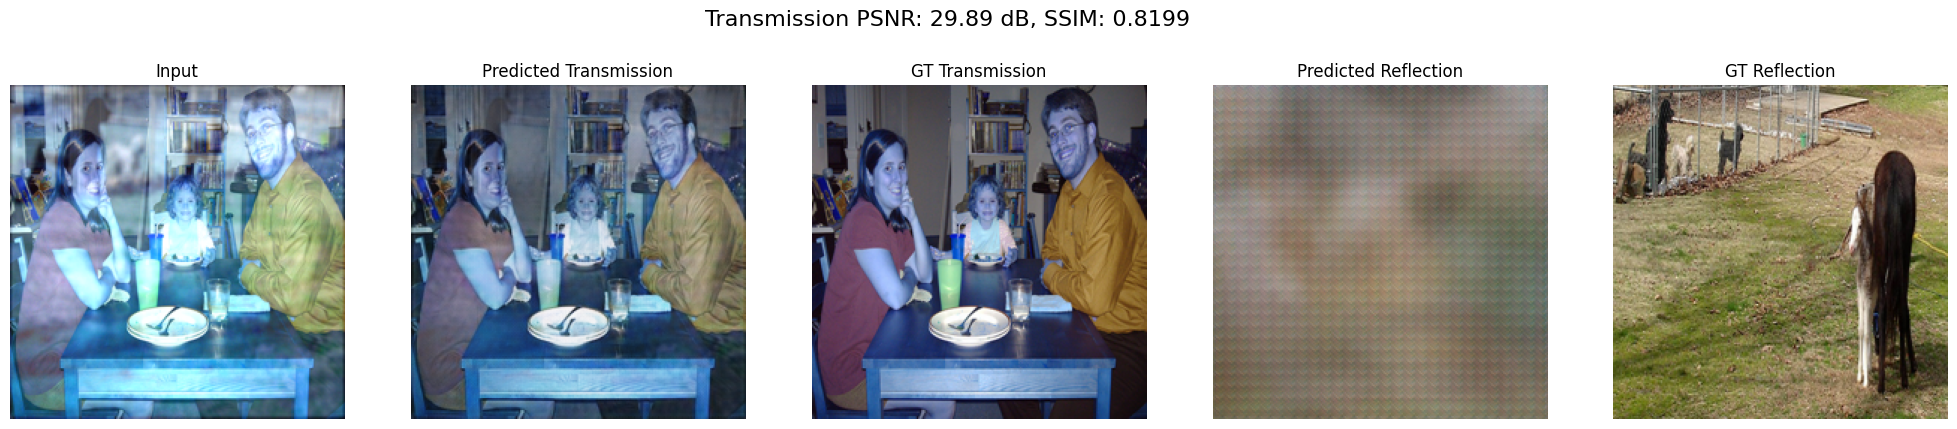

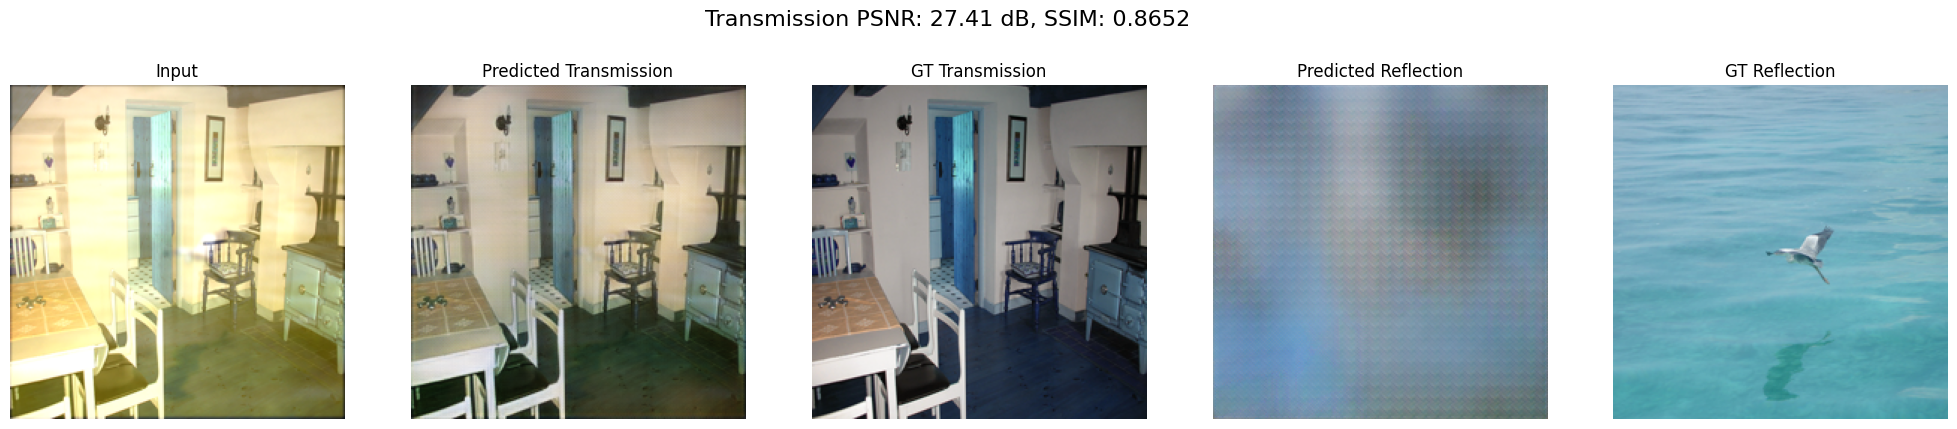

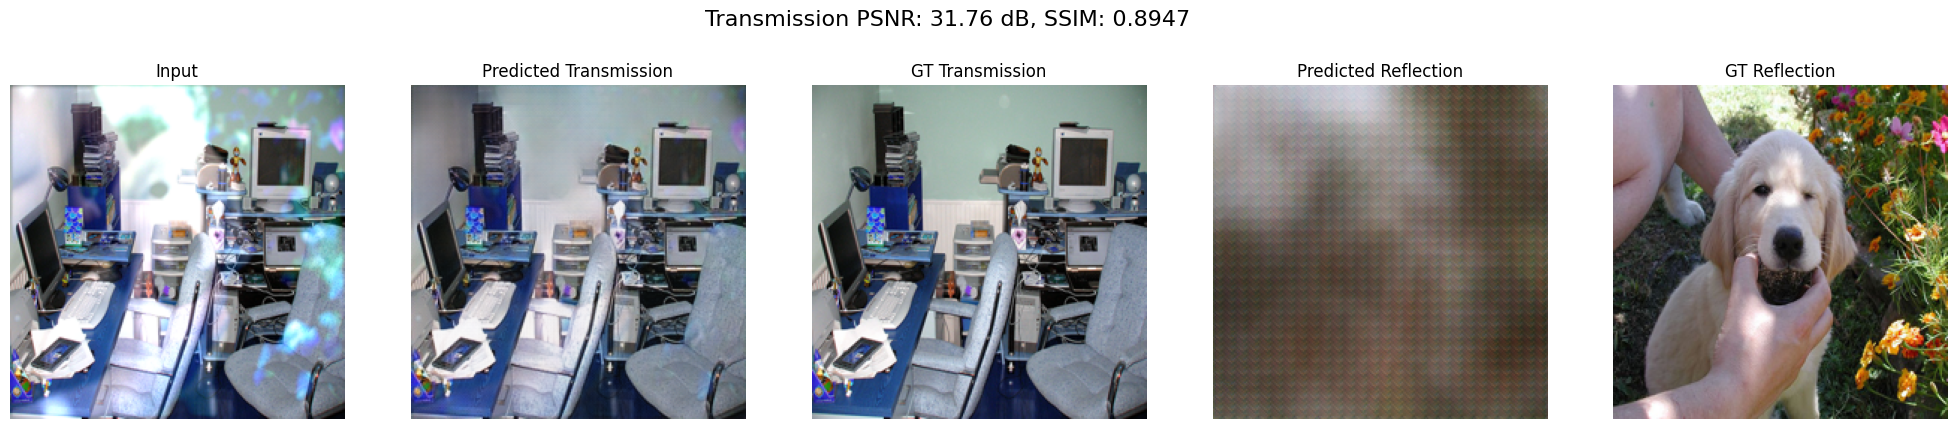

In [44]:
def evaluate_model(model, dataloader, device):
    """
    Evaluates the model on the given dataloader using PSNR and SSIM.
    Calculates average scores over the whole dataset and visualizes a few examples.
    """
    psnr_metric = torchmetrics.PeakSignalNoiseRatio().to(device)
    ssim_metric = torchmetrics.StructuralSimilarityIndexMeasure().to(device)
    
    model.eval()
    print("🔍 Running Final Evaluation with TorchMetrics...")
    with torch.no_grad():
        for data in tqdm(dataloader, desc="Calculating Metrics"):
            blended, gt_transmission = data['blended'].to(device), data['transmission'].to(device)
            pred_transmission, _ = model(blended)
            
            psnr_metric.update(pred_transmission, gt_transmission)
            ssim_metric.update(pred_transmission, gt_transmission)

    avg_psnr = psnr_metric.compute()
    avg_ssim = ssim_metric.compute()
    
    print(f"\n✅ Evaluation Complete")
    print(f"Average PSNR: {avg_psnr:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")

    # --- Visualization Part ---
    print("\nDisplaying a few examples...")
    psnr_metric.reset(); ssim_metric.reset()
    
    data_vis = next(iter(dataloader))
    blended_vis, t_vis, r_vis = \
        data_vis['blended'].to(device), data_vis['transmission'].to(device), data_vis['reflection'].to(device)
    p_t_vis, p_r_vis = model(blended_vis)

    for i in range(min(len(blended_vis), 3)):
        p_t_single = p_t_vis[i].unsqueeze(0)
        t_single = t_vis[i].unsqueeze(0)

        image_psnr = psnr_metric(p_t_single, t_single)
        image_ssim = ssim_metric(p_t_single, t_single)

        # --- FIX IS HERE: Add .detach() to all model outputs ---
        images = {
            "Input": blended_vis[i].cpu().detach(),
            "Predicted Transmission": p_t_single.cpu().detach().squeeze(0),
            "GT Transmission": t_single.cpu().squeeze(0), # Ground truth doesn't need detach
            "Predicted Reflection": p_r_vis[i].cpu().detach(),
            "GT Reflection": r_vis[i].cpu() # Ground truth doesn't need detach
        }
        
        fig, axs = plt.subplots(1, 5, figsize=(25, 5))
        fig.suptitle(f"Transmission PSNR: {image_psnr:.2f} dB, SSIM: {image_ssim:.4f}", fontsize=16)

        for ax, (title, img) in zip(axs, images.items()):
            # Now this will work correctly
            img_np = img.permute(1, 2, 0).numpy()
            ax.imshow(np.clip(img_np, 0, 1))
            ax.set_title(title)
            ax.axis('off')
        plt.show()

print("\n🔍 Running Final Evaluation on the Best Model...")
evaluate_model(model, val_loader, device)

In [ ]:
# def organize_robust_reflection_dataset(voc_path='VOC2012'):
#     # Verify structure
#     required_folders = ['blended', 'transmission_layer']
#     if not all(os.path.exists(os.path.join(voc_path, folder)) for folder in required_folders):
#         print(f"Error: Missing folders in {voc_path}. Expected {required_folders}")
#         return None
    
#     # Collect pairs
#     blended_files = sorted(glob.glob(os.path.join(voc_path, 'blended', '*.png')))
#     trans_files = sorted(glob.glob(os.path.join(voc_path, 'transmission_layer', '*.png')))
    
#     # Match pairs (assuming filenames align, e.g., "2010_000697-2009_001607.png" and "2010_000697.png")
#     pairs = []
#     for blended in blended_files:
#         base_name = blended.split('-')[0].replace(os.path.join(voc_path, 'blended'), '').replace('.png', '')
#         for trans in trans_files:
#             if trans.endswith(base_name + '.png'):
#                 pairs.append((blended, trans))
#                 break
    
#     if len(pairs) == 0:
#         print("Error: No pairs matched. Check filename consistency (e.g., '2010_000697-2009_001607.png' and '2010_000697.png').")
#         return None
    
#     # Split into train/val/test (70%/10%/20%)
#     train_pairs, temp_pairs = train_test_split(pairs, train_size=0.7, random_state=42)
#     val_pairs, test_pairs = train_test_split(temp_pairs, train_size=0.333, random_state=42)  # 10% val, 20% test of remaining
#     dataset = {'train': train_pairs, 'val': val_pairs, 'test': test_pairs}
    
#     print(f"Training: {len(dataset['train'])} pairs")
#     print(f"Validation: {len(dataset['val'])} pairs")
#     print(f"Test: {len(dataset['test'])} pairs")
#     return dataset

# # Run organization
# dataset_splits = organize_robust_reflection_dataset()
# if dataset_splits is None:
#     print("Dataset organization failed. Ensure VOC2012/ is in the working directory or download it.")

In [ ]:
# def download_sir2_dataset(save_path='SIR2', zip_url='https://www.dropbox.com/scl/fi/qgg1whla1jb3a9cgis18l/SIR2.zip?rlkey=kmhrc2uk63be2s9hzr43gc3hm&dl=1'):
#     # Check if main dataset is already extracted
#     if os.path.exists(os.path.join(save_path, 'Postcard Dataset')) and \
#        os.path.exists(os.path.join(save_path, 'SolidObjectDataset')) and \
#        os.path.exists(os.path.join(save_path, 'Wildscene')):
#         print(f"Dataset already extracted at {save_path}")
#         return
    
#     # Download main ZIP
#     if os.path.exists(save_path):
#         print(f"Dataset already downloaded at {save_path}")  
#     else:
#         os.makedirs(save_path)
#         print("Downloading SIR² dataset...")
#         zip_path = os.path.join(save_path, 'SIR2.zip')
#         response = requests.get(zip_url, stream=True)
#         total_size = int(response.headers.get('content-length', 0))
#         block_size = 1024  # 1 KB
    
#         with open(zip_path, 'wb') as file, tqdm(
#             desc=zip_path,
#             total=total_size,
#             unit='iB',
#             unit_scale=True
#         ) as bar:
#             for data in response.iter_content(block_size):
#                 bar.update(len(data))
#                 file.write(data)
        
#         # Extract main ZIP
#         print("Extracting main ZIP...")
#         with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#             zip_ref.extractall(save_path)
#         os.remove(zip_path)
    
#     # Extract nested ZIPs
#     print("Extracting nested ZIPs...")
#     nested_zips = ['Postcard Dataset.zip', 'SolidObjectDataset.zip', 'Wildscene.zip']
#     for zip_name in nested_zips:
#         nested_zip_path = os.path.join(save_path, zip_name)
#         if not os.path.exists(nested_zip_path):
#             print(f"Warning: {zip_name} not found in {save_path}")
#             continue
        
#         # For Wildscene.zip, create Wildscene/ subfolder first
#         extract_path = save_path
#         if zip_name == 'Wildscene.zip':
#             extract_path = os.path.join(save_path, 'Wildscene')
#             os.makedirs(extract_path, exist_ok=True)
        
#         # Extract ZIP
#         with zipfile.ZipFile(nested_zip_path, 'r') as zip_ref:
#             zip_ref.extractall(extract_path)
#         os.remove(nested_zip_path)
#         print(f"Extracted {zip_name} to {extract_path}")
    
#     print(f"Dataset fully extracted to {save_path}")

# # Run the download and extraction (comment out after first run)
# download_sir2_dataset()